# Import Libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import cross_validate, KFold
from sklearn.metrics import mean_squared_error
import numpy as np
import seaborn as sns
import category_encoders as ce


# Read Data

In [254]:
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")

train.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031


In [255]:
train.columns

Index(['id', 'Podcast_Name', 'Episode_Title', 'Episode_Length_minutes',
       'Genre', 'Host_Popularity_percentage', 'Publication_Day',
       'Publication_Time', 'Guest_Popularity_percentage', 'Number_of_Ads',
       'Episode_Sentiment', 'Listening_Time_minutes'],
      dtype='object')

In [256]:
train.describe()

,id,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Listening_Time_minutes
count,750000.000000,662907.000000,750000.000000,603970.000000,749999.000000,750000.000000
mean,374999.500000,64.504738,59.859901,52.236449,1.348855,45.437406
std,216506.495284,32.969603,22.873098,28.451241,1.151130,27.138306
min,0.000000,0.000000,1.300000,0.000000,0.000000,0.000000
25%,187499.750000,35.730000,39.410000,28.380000,0.000000,23.178350
50%,374999.500000,63.840000,60.050000,53.580000,1.000000,43.379460
75%,562499.250000,94.070000,79.530000,76.600000,2.000000,64.811580
max,749999.000000,325.240000,119.460000,119.910000,103.910000,119.970000


In [257]:
train.shape

(750000, 12)

# Data Cleaning

In [258]:
# episode length 0 doesn't make sense, drop
train = train[train.Episode_Length_minutes != 0]

# percentages above 100 don't make sense, drop
train = train[train.Host_Popularity_percentage <= 100]
train = train[train.Guest_Popularity_percentage <= 100]

# number of ads should only be 0 to 3
train = train[train.Number_of_Ads <= 3]


In [259]:
train.shape

(603918, 12)

In [260]:
# keep in mind that there are podcasts with 0 mins listening time
train[train.Listening_Time_minutes == 0]

print(train.shape)
# DROP FOR NOW
train = train[train.Listening_Time_minutes > 0]
print(train.shape)


(603918, 12)
(598494, 12)


In [261]:
# drop id, it doesnt make sense
train = train.drop(['id'], axis=1)

In [262]:
# checking to see how many null values we have in each of the other columns
columns_with_nulls = []
for column in train.columns:
    if train.loc[:, column].isnull().any():
        columns_with_nulls.append(column)

for column in columns_with_nulls:
    percent_missing = round(((train.loc[train.loc[:, column].isnull()].shape[0] / train.shape[0]) * 100), 4)
    print("Column {} has {}% missing values \n".format(column, percent_missing))

Column Episode_Length_minutes has 10.77% missing values 



In [263]:
# DROP FOR NOw
train.drop(columns=columns_with_nulls,axis=1)

,Podcast_Name,Episode_Title,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
1,Joke Junction,Episode 26,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,Study Sessions,Episode 16,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,Digital Digest,Episode 45,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,Mind & Body,Episode 86,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031
6,Criminal Minds,Episode 47,True Crime,35.82,Sunday,Night,39.02,0.0,Neutral,64.75024
...,...,...,...,...,...,...,...,...,...,...
749992,Fashion Forward,Episode 75,Lifestyle,88.62,Wednesday,Evening,25.65,3.0,Positive,42.08465
749993,Style Guide,Episode 83,Lifestyle,38.14,Tuesday,Evening,86.17,0.0,Neutral,19.71374
749997,Lifestyle Lounge,Episode 51,Lifestyle,78.58,Thursday,Morning,84.89,0.0,Negative,15.26000
749998,Style Guide,Episode 47,Lifestyle,45.39,Thursday,Morning,93.27,0.0,Negative,100.72939


# Outliers

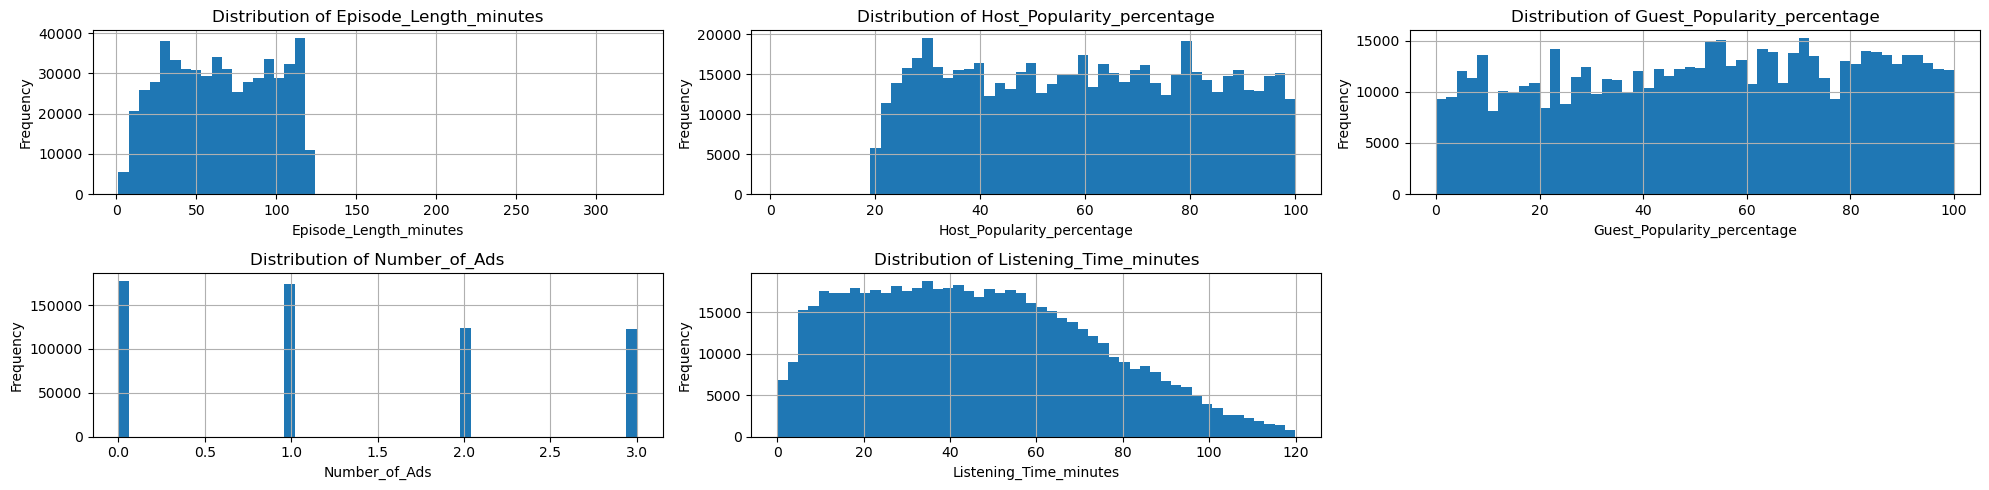

In [264]:
# Identify numeric and categorical columns
numeric_columns = train.select_dtypes(include=['number']).columns
categorical_columns = train.select_dtypes(include=['object', 'category']).columns

# Plot distributions for numeric features
plt.figure(figsize=(20, 5))
for i, column in enumerate(numeric_columns):
    plt.subplot(len(numeric_columns) // 3 + 1, 3, i + 1)  # Arrange histograms in a grid
    train[column].hist(bins=50)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [265]:
# Identify numeric columns
numeric_columns = train.select_dtypes(include=['number']).columns

# Calculate mean and standard deviation for each numeric column
mean = train[numeric_columns].mean()
std = train[numeric_columns].std()

# Define the upper and lower bounds for each column using 3 standard deviations
upper_bound = mean + 2.5 * std
lower_bound = mean - 2.5 * std

# Create a mask to identify rows within the bounds (excluding outliers)
outlier_mask = (train[numeric_columns] >= lower_bound) & (train[numeric_columns] <= upper_bound)

print(f"Original shape: {train.shape}")

# Keep only the rows where all numeric columns are within the bounds
train = train[outlier_mask.all(axis=1)]

# Show the result
print(f"Filtered shape: {train.shape}")


Original shape: (598494, 11)
Filtered shape: (531170, 11)


# Feature Selection and Engineering

In [266]:
train.columns

Index(['Podcast_Name', 'Episode_Title', 'Episode_Length_minutes', 'Genre',
       'Host_Popularity_percentage', 'Publication_Day', 'Publication_Time',
       'Guest_Popularity_percentage', 'Number_of_Ads', 'Episode_Sentiment',
       'Listening_Time_minutes'],
      dtype='object')

In [267]:
# Episode title transform to numeric
train.Episode_Title = train.Episode_Title.str.split().str[1]
train.Episode_Title = pd.to_numeric(train.Episode_Title)

In [ ]:
# Add percentage listened
# Correct way to create or modify columns in pandas
train['Percentage_Listened'] = train['Listening_Time_minutes'] / train['Episode_Length_minutes']

In [275]:
y = train.Listening_Time_minutes
X = train.drop(['Listening_Time_minutes'], axis=1)

/tmp/ipykernel_26177/3581310958.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = X.corr()


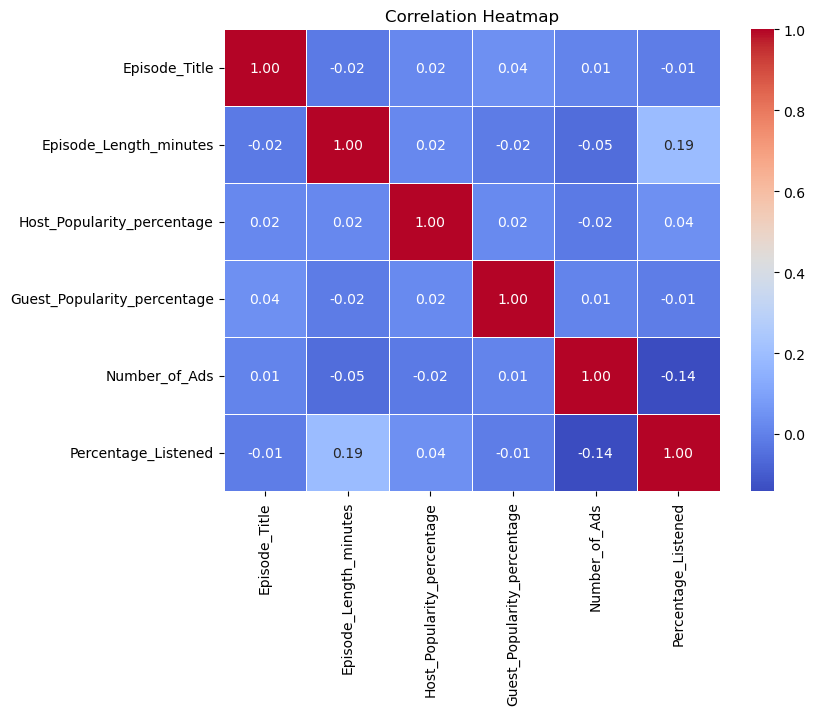

In [276]:
# Calculate the correlation matrix
corr_matrix = X.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Display the plot
plt.title('Correlation Heatmap')
plt.show()

In [277]:
# Identify numeric and categorical columns
numerical_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

categorical_cols


['Podcast_Name',
 'Genre',
 'Publication_Day',
 'Publication_Time',
 'Episode_Sentiment']

In [ ]:
# Preprocessing for numerical data (Scale only)
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with the mean
    ('scaler', StandardScaler())  # Only scale numerical data
])

# Preprocessing for categorical data (OneHot Encoding only)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing values with the most frequent value
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical features
])

# Define the target encoder (from category_encoders)
target_encoder = ce.TargetEncoder(cols=['Genre'])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Full pipeline with target encoding for 'Genre' and regression
model = Pipeline(steps=[
    ('target_encoder', target_encoder),  # Target encode the 'Genre' column
    ("preprocessor", preprocessor),  # Apply other preprocessing
    ("regressor", LinearRegression())  # Linear Regression model
])

In [ ]:
# Cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    'rmse': 'neg_root_mean_squared_error'
}

results = cross_validate(model, X, y, cv=cv, scoring=scoring)

# --- Display Results ---
print("Cross-Validation Results (5-Fold):")
print(f"RMSE: {-results['test_rmse'].mean():.2f}")

/home/francesca/anaconda3/envs/ds_env/lib/python3.10/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif pd.api.types.is_categorical(cols):
/home/francesca/anaconda3/envs/ds_env/lib/python3.10/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif pd.api.types.is_categorical(cols):
/home/francesca/anaconda3/envs/ds_env/lib/python3.10/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif pd.api.types.is_categorical(cols):
/home/francesca/anaconda3/envs/ds_env/lib/python3.10/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif

Cross-Validation Results (5-Fold):
RMSE: 7.58
